In [1]:
import models 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary  
from tqdm import tqdm
import cv2
import albumentations as A 
import numpy as np
import splitfolders
import matplotlib.pyplot as plt 
import os 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
unet_summary = models.UNet(2, 0.15, 3, True, 5) 
summary(unet_summary, input_size=(8,3,128,128), device='cpu', col_names=("input_size", "output_size", "num_params")) 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet                                     [8, 3, 128, 128]          [8, 2, 128, 128]          --
├─ModuleList: 1-53                       --                        --                        (recursive)
│    └─BatchNorm2d: 2-1                  [8, 3, 128, 128]          [8, 3, 128, 128]          6
├─ModuleList: 1-52                       --                        --                        (recursive)
│    └─DoubleConv: 2-2                   [8, 3, 128, 128]          [8, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [8, 3, 128, 128]          [8, 64, 128, 128]         1,792
│    │    └─BatchNorm2d: 3-2             [8, 64, 128, 128]         [8, 64, 128, 128]         128
│    │    └─Dropout: 3-3                 [8, 64, 128, 128]         [8, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [8, 64, 128, 128]         [8, 64, 128, 128]         36,928
├─MaxPool2

[0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] (256, 256)


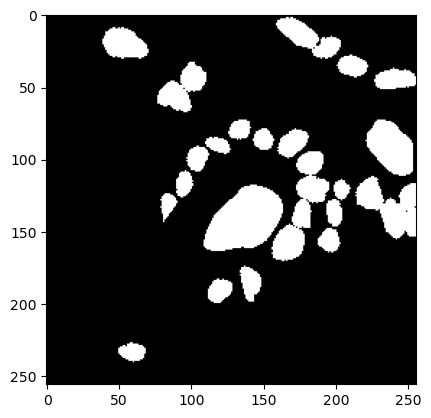

(256, 256, 3)


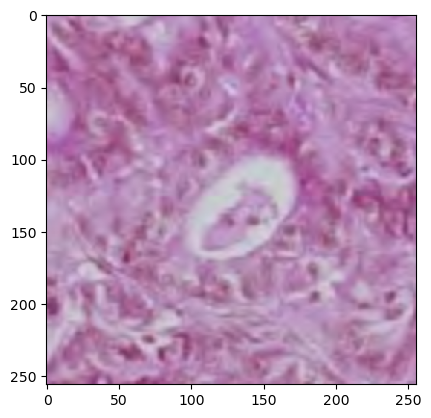

In [3]:
mask = cv2.imread(f'data/mask/1122.png', cv2.IMREAD_UNCHANGED)
binary_mask = (mask > 0).astype(np.uint8)
print(np.unique(binary_mask))
print(np.unique(mask), np.shape(mask))
plt.imshow(binary_mask, vmin=0, vmax=1, cmap='gray')
plt.show()
img = cv2.imread('data/img/1122.png')
print(img.shape)
plt.imshow(img)

In [4]:
imgs = sorted(os.listdir('data/img/'))
masks = sorted(os.listdir('data/mask/'))
for i in range(len(masks)):
    if masks[i] != imgs[i]:
        print(masks[i], imgs[i])
print(len(imgs), len(masks))

1356 1356


# Datasets and Dataloaders

In [5]:
class NucleusDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir 
        self.mask_dir = mask_dir 
        assert len(os.listdir(self.image_dir)) == len(os.listdir(self.mask_dir)), 'Must have the same number of images and masks'
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.image_dir))
        
    def __getitem__(self, index):
        image_name = sorted(os.listdir(self.image_dir))[index]
        mask_name = sorted(os.listdir(self.mask_dir))[index]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  
        
        binary_mask = (mask > 0).astype(np.int64)
        
        if self.transform:
            augmentations = self.transform(image=image, mask=binary_mask)
            image = augmentations['image']
            binary_mask = augmentations['mask']
            
        assert image.shape == (256, 256, 3), 'Incorrect image shape' 
        assert binary_mask.shape == (256, 256), 'Incorrect mask shape'
        
        image = image.astype(np.float32)
        binary_mask = binary_mask.astype(np.int64)
        
        image = torch.from_numpy(image) 
        image = torch.permute(image, (2, 0 ,1))
        binary_mask = torch.from_numpy(binary_mask)
            
        return image, binary_mask

In [6]:
# splitfolders.ratio('data', ratio=(0.8, 0.2))  # splitting into train and val 

In [6]:
train_imgs = os.path.join('output', 'train', 'img')
train_masks = os.path.join('output', 'train', 'mask')
val_imgs = os.path.join('output', 'val', 'img')
val_masks = os.path.join('output', 'val', 'mask')

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(p=0.5),
        A.RandomResizedCrop(height=256, width=256, p=0.5),
        A.GaussianBlur(blur_limit=(1, 5), p=0.5),
        A.Defocus(radius=(3, 8), alias_blur=(0.1, 0.3), p=0.5),
    ]
)

train_dataset = NucleusDataset(train_imgs, train_masks, transform=transform)
val_dataset = NucleusDataset(val_imgs, val_masks)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

# Training loop

In [7]:
def val_loss(val_dataloader, loss_fn, device, model):  # with torch.no_grad()! And model.eval()! 
    temp = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            unet_raw_masks = model(images)
            loss = loss_fn(unet_raw_masks, masks)
            temp += loss 
    model.train() 
    return temp/batch_idx     

In [9]:
learning_rate = 1e-4 
num_epochs = 50
drop_rate = 0.8
invert = False
depth = 4

unet = models.UNet(num_classes=2, drop_rate=drop_rate, input_channels=3, invert=invert, depth=depth).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
train_loss_arr = np.zeros(num_epochs)
val_loss_arr = np.zeros(num_epochs)
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(num_epochs)):
    temp = 0
    for batch_idx, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        with torch.cuda.amp.autocast():
            unet_raw_masks = unet(images)
            loss = loss_fn(unet_raw_masks, masks)
        temp += loss 
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update() 
    train_loss_arr[epoch] = temp/batch_idx
    val_loss_arr[epoch] = val_loss(val_dataloader=val_dataloader, loss_fn=loss_fn, device=device, model=unet) 

 68%|██████▊   | 34/50 [3:16:09<1:04:46, 242.90s/it] 

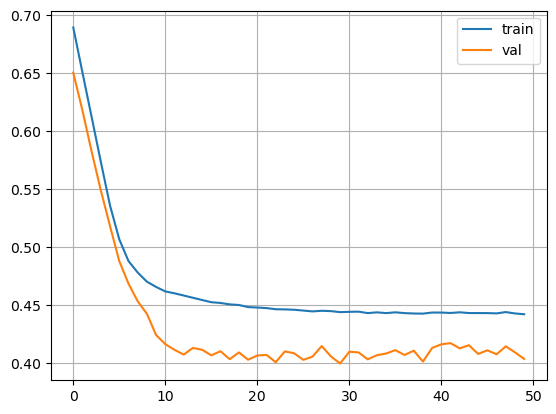

In [10]:
plt.plot(np.arange(num_epochs), train_loss_arr, label='train')
plt.plot(np.arange(num_epochs), val_loss_arr, label='val')
plt.legend()
plt.grid()
plt.show()

In [11]:
# RUN THIS CAREFULLY 
torch.save({
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_arr': train_loss_arr, 
            'val_loss_arr': val_loss_arr,
            'last_epoch': epoch
            }, f'C:/Users/Temirkul/Desktop/Temirkul/quantori unet (send to laptop)/saves/unet_{num_epochs}epoch_{drop_rate}_{learning_rate}_invert{invert}_{depth}.pt')

In [11]:
# RUN THIS CAREFULLY (if transform)
torch.save({
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_arr': train_loss_arr, 
            'val_loss_arr': val_loss_arr,
            'last_epoch': epoch
            }, f'C:/Users/Temirkul/Desktop/Temirkul/quantori unet (send to laptop)/saves/unet_{num_epochs}epoch_{drop_rate}_{learning_rate}_invert{invert}_{depth}_transform.pt')

# Visualizing UNet masks

In [12]:
val_imgs, val_masks = next(iter(val_dataloader))
print(val_imgs.shape, val_masks.shape)

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


In [13]:
unet.eval()
val_imgs, val_masks = next(iter(val_dataloader))
print(val_imgs.shape, val_masks.shape)
unet_masks = unet(val_imgs.to(device))
converted_masks = torch.argmax(unet_masks, dim=1)
val_imgs = torch.permute(val_imgs, (0, 2, 3, 1)).to(torch.int64)

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


torch.Size([8, 256, 256, 3]) torch.Size([8, 256, 256])


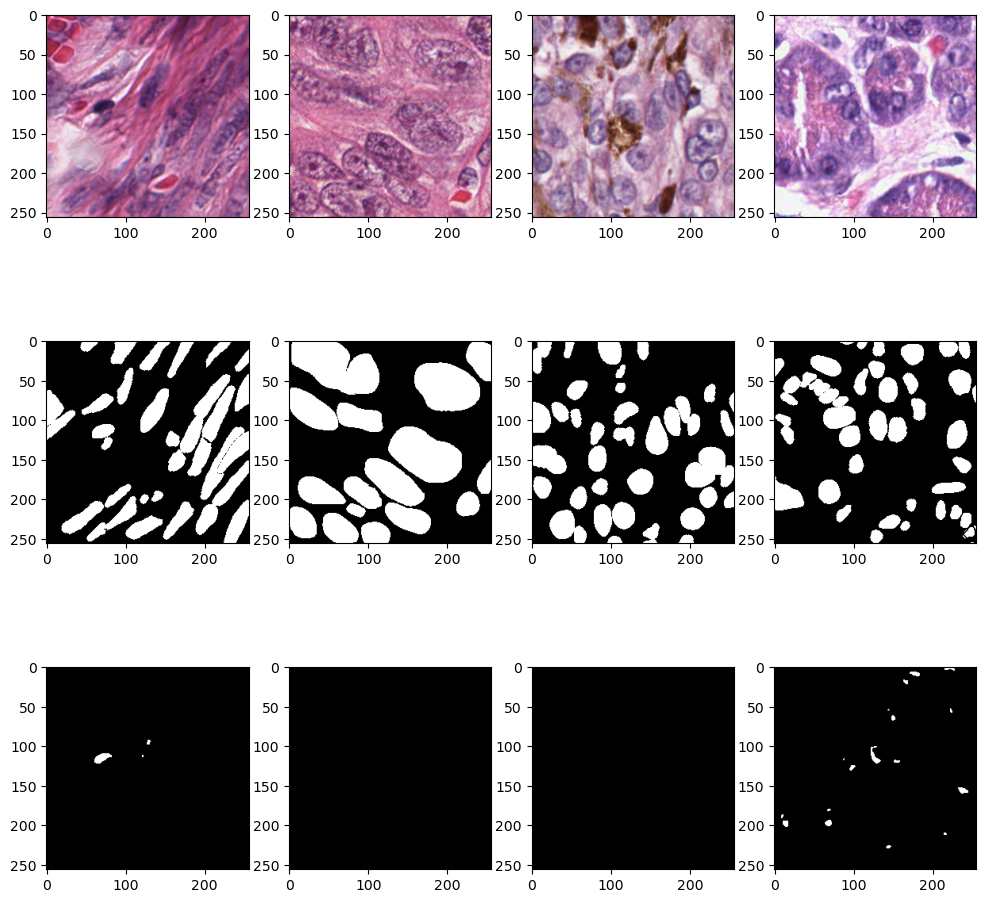

In [14]:
size = 12
divisor = 2
fig, axs = plt.subplots(3, batch_size//divisor, figsize=(size, size))  
converted_masks = converted_masks.to('cpu')
print(val_imgs.shape, converted_masks.shape,)

for j in range(batch_size//divisor):
    axs[0, j].imshow(val_imgs[j, :, :, :])
    axs[1, j].imshow(val_masks[j, :, :], cmap='gray')
    axs[2, j].imshow(converted_masks[j, :, :], cmap='gray')

# Visualizing train data

In [8]:
train_imgs, train_masks = next(iter(train_dataloader))
print(train_imgs.shape, train_masks.shape)
train_imgs = torch.permute(train_imgs, (0, 2, 3, 1)).to(torch.int64)
print(train_imgs.shape)

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
torch.Size([8, 256, 256, 3])


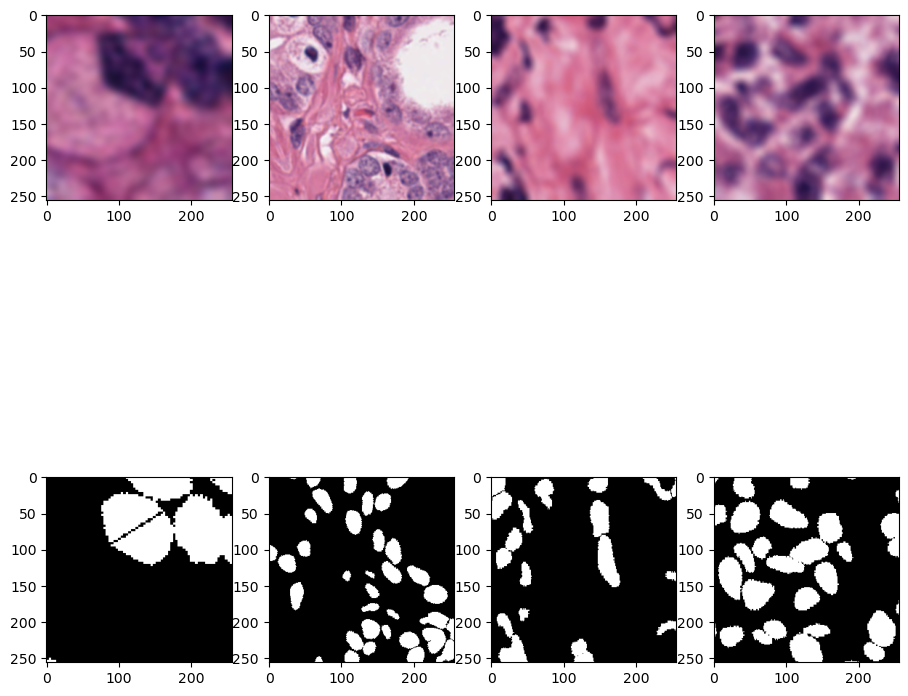

In [10]:
size = 11
divisor = 2
fig, axs = plt.subplots(2, batch_size//divisor, figsize=(size, size))

for j in range(batch_size//divisor):
    axs[0, j].imshow(train_imgs[j, :, :, :])
    axs[1, j].imshow(train_masks[j, :, :], cmap='gray')